In [1]:
import argparse
import os
import glob
import pandas as pd
import pickle
import numpy as np
import pprint
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import col

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.sklearn

import tempfile
import pickle
import os


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.calibration import calibration_curve

In [4]:
# Initialize Spark
spark = pyspark.sql.SparkSession.builder.appName("TrainLR").master("local[*]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/11 03:47:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
snapshotdate = "2024-08-01"

In [6]:
# --- Configuration ---
model_train_date_str = snapshotdate
train_test_period_months = 12
oot_period_months = 2
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] = oot_period_months
config["model_train_date"] = datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] = config['model_train_date'] - timedelta(days=1)
config["oot_start_date"] = config['model_train_date'] - relativedelta(months=oot_period_months)
config["train_test_end_date"] = config["oot_start_date"] - timedelta(days=1)
config["train_test_start_date"] = config["oot_start_date"] - relativedelta(months=train_test_period_months)
config["train_test_ratio"] = train_test_ratio
pprint.pprint(config)

{'model_train_date': datetime.datetime(2024, 8, 1, 0, 0),
 'model_train_date_str': '2024-08-01',
 'oot_end_date': datetime.datetime(2024, 7, 31, 0, 0),
 'oot_period_months': 2,
 'oot_start_date': datetime.datetime(2024, 6, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2024, 5, 31, 0, 0),
 'train_test_period_months': 12,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(2023, 6, 1, 0, 0)}


In [7]:
# --- get label ---
LABEL_DIR = "/app/datamart/gold/label_store"
# Find subdirectories that look like *.parquet (folders, not files)
subfolders = sorted([os.path.join(LABEL_DIR, d) for d in os.listdir(LABEL_DIR) if d.endswith(".parquet")])

if not subfolders:
    raise FileNotFoundError(f"No label snapshot folders found in {LABEL_DIR}")

print(f"📂 Found {len(subfolders)} label snapshots")
label_store_sdf = spark.read.parquet(*subfolders)
print("✅ row_count:", label_store_sdf.count())
    
label_store_sdf.show(5)

# extract label store
labels_sdf = label_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))
print("extracted labels_sdf", labels_sdf.count(), config["train_test_start_date"], config["oot_end_date"])


📂 Found 24 label snapshots


✅ row_count: 11459
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x10ac_2024_0...| CUS_0x10ac|    0|30dpd_1mob|   2024-09-01|
|CUS_0x10c5_2024_0...| CUS_0x10c5|    1|30dpd_1mob|   2024-09-01|
|CUS_0x1145_2024_0...| CUS_0x1145|    0|30dpd_1mob|   2024-09-01|
|CUS_0x11ac_2024_0...| CUS_0x11ac|    0|30dpd_1mob|   2024-09-01|
|CUS_0x122c_2024_0...| CUS_0x122c|    0|30dpd_1mob|   2024-09-01|
+--------------------+-----------+-----+----------+-------------+
only showing top 5 rows



[Stage 5:>                                                          (0 + 8) / 8]

extracted labels_sdf 6927 2023-06-01 00:00:00 2024-07-31 00:00:00


In [8]:
# --- get features ---
FEATURE_DIR = "/app/datamart/gold/feature_store"
subfolders = sorted([os.path.join(FEATURE_DIR, d) for d in os.listdir(FEATURE_DIR) if d.startswith("snapshot_date=")])

if not subfolders:
    raise FileNotFoundError(f"No snapshot_date folders found in {FEATURE_DIR}")

print(f"📂 Found {len(subfolders)} feature snapshots")
features_store_sdf = spark.read.parquet(*subfolders)
print("✅ row_count:", features_store_sdf.count())

features_store_sdf.show(5)

# extract feature store
try:
    features_sdf = features_store_sdf.filter(
        (col("snapshot_date") >= config["train_test_start_date"]) &
        (col("snapshot_date") <= config["oot_end_date"])
    )
except Exception as e:
    print(f"⚠️ Using application_date instead of snapshot_date due to: {e}")
    features_sdf = features_store_sdf.filter(
        (col("application_date") >= config["train_test_start_date"]) &
        (col("application_date") <= config["oot_end_date"])
    )
    
print("extracted features_sdf", features_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

📂 Found 25 feature snapshots


✅ row_count: 12500
+-----------+----------------+-------------+----------------+------------------+-----------+----------------------+-------------------+-------------------------------------------------+------------------------------------------------+-------------------------------------------------+------------------------------------------------+--------------------------------------------------+-------------------------------------------------+-------------------+---------------+--------------+----------------------+--------------------------------+--------------------------+-----------------------------+--------------------------+-------------------------+------------------------------------+------------------------+-------------+----------------+--------------+--------------+--------------+--------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+------

[Stage 13:========>                                                 (1 + 6) / 7]

extracted features_sdf 6911 2023-06-01 00:00:00 2024-07-31 00:00:00


In [9]:
# --- Prepare training data ---
data_pdf = labels_sdf.join(features_sdf, on=["Customer_ID"], how="inner").toPandas()

oot_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["oot_start_date"].date()) &
    (data_pdf['snapshot_date'] <= config["oot_end_date"].date())
]
train_test_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["train_test_start_date"].date()) &
    (data_pdf['snapshot_date'] <= config["train_test_end_date"].date())
]

In [10]:
# --- Train/test split ---
feature_cols = [fe_col for fe_col in features_sdf.columns if fe_col not in ['Customer_ID', 'application_date', 'snapshot_date']]

X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]
X_train, X_test, y_train, y_test = train_test_split(
    train_test_pdf[feature_cols],
    train_test_pdf["label"],
    test_size=1 - config["train_test_ratio"],
    random_state=88,
    shuffle=True,
    stratify=train_test_pdf["label"]
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}, OOT size: {X_oot.shape[0]}")

Train size: 4333, Test size: 1084, OOT size: 989


In [11]:
# --- Preprocessing ---
# --- Handle missing values ---
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)
X_oot   = X_oot.fillna(0)

In [12]:
# --- Scaling ---
scaler = StandardScaler()
transformer_stdscaler = scaler.fit(X_train)
X_train_processed = transformer_stdscaler.transform(X_train)
X_test_processed = transformer_stdscaler.transform(X_test)
X_oot_processed = transformer_stdscaler.transform(X_oot)

In [13]:
# --- Model training ---
log_reg = LogisticRegression(solver='liblinear', random_state=88, max_iter=1000)
param_dist = {
    'C': np.logspace(-3, 3, 10),
    'penalty': ['l1', 'l2']
}

random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    scoring='roc_auc',
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_processed, y_train)
print("Best parameters:", random_search.best_params_)
print("Best AUC:", random_search.best_score_)

best_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'penalty': 'l1', 'C': np.float64(0.46415888336127775)}
Best AUC: 0.7564618815116683


In [14]:
# --- Evaluate ---
def eval_auc(X, y):
    y_pred_proba = best_model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, y_pred_proba)
    return auc, round(2 * auc - 1, 3)

train_auc, train_gini = eval_auc(X_train_processed, y_train)
test_auc, test_gini = eval_auc(X_test_processed, y_test)
oot_auc, oot_gini = eval_auc(X_oot_processed, y_oot)

print("Train AUC:", train_auc, "GINI:", train_gini)
print("Test AUC:", test_auc, "GINI:", test_gini)
print("OOT AUC:", oot_auc, "GINI:", oot_gini)

Train AUC: 0.8213227578212032 GINI: 0.643
Test AUC: 0.7209894258528502 GINI: 0.442
OOT AUC: 0.8053422182064603 GINI: 0.611


In [15]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## FEATURE IMPORTANCE (Coefficient-based)

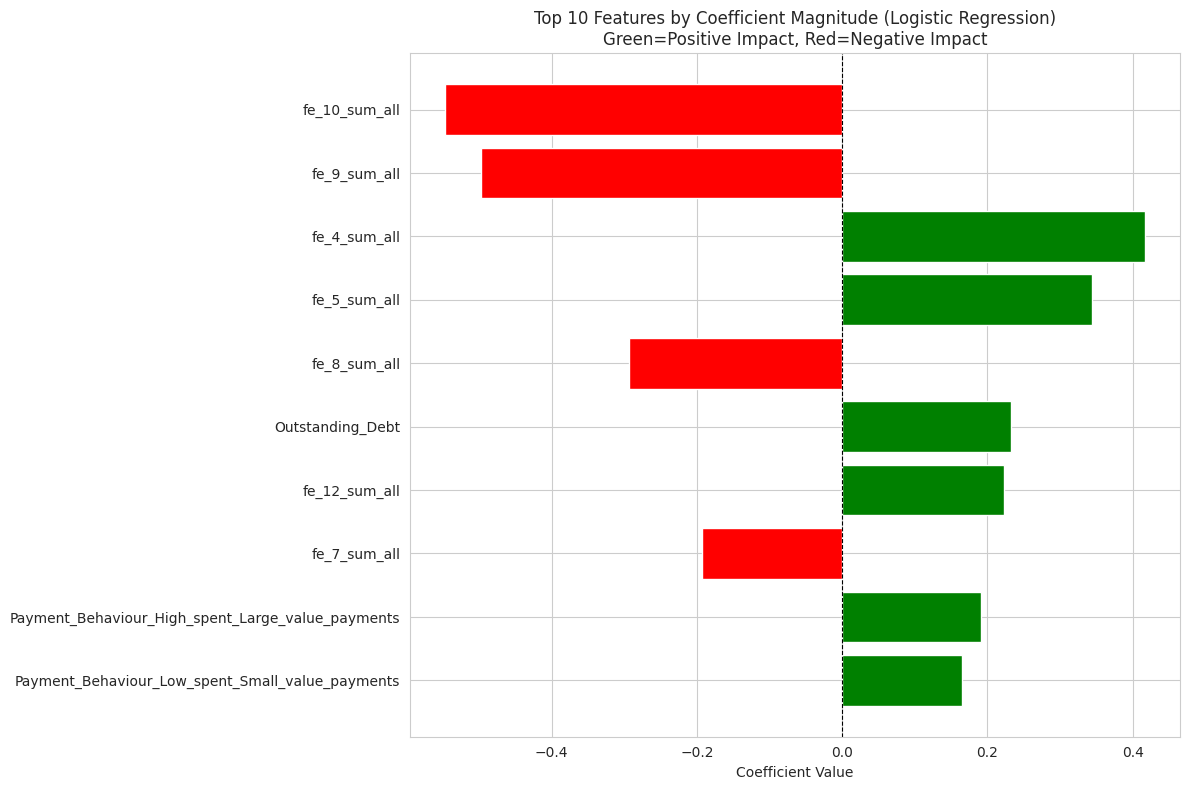


Top 10 Features:
                                              feature  coefficient  \
39                                      fe_10_sum_all    -0.546702   
38                                       fe_9_sum_all    -0.496966   
33                                       fe_4_sum_all     0.417085   
34                                       fe_5_sum_all     0.343651   
37                                       fe_8_sum_all    -0.292995   
1                                    Outstanding_Debt     0.232053   
41                                      fe_12_sum_all     0.222359   
36                                       fe_7_sum_all    -0.193385   
11  Payment_Behaviour_High_spent_Large_value_payments     0.190617   
9    Payment_Behaviour_Low_spent_Small_value_payments     0.165496   

    abs_coefficient  
39         0.546702  
38         0.496966  
33         0.417085  
34         0.343651  
37         0.292995  
1          0.232053  
41         0.222359  
36         0.193385  
11         0.

In [37]:
# ============================================
# 1. FEATURE IMPORTANCE (Coefficient-based)
# ============================================
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': best_model.coef_[0],
    'abs_coefficient': np.abs(best_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False).head(10)

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in feature_importance_df['coefficient']]
plt.barh(range(len(feature_importance_df)), feature_importance_df['coefficient'], color=colors)
plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Features by Coefficient Magnitude (Logistic Regression)\nGreen=Positive Impact, Red=Negative Impact')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Features:")
print(feature_importance_df[['feature', 'coefficient', 'abs_coefficient']])

## ROC CURVES (Train/Test/OOT on same plot)

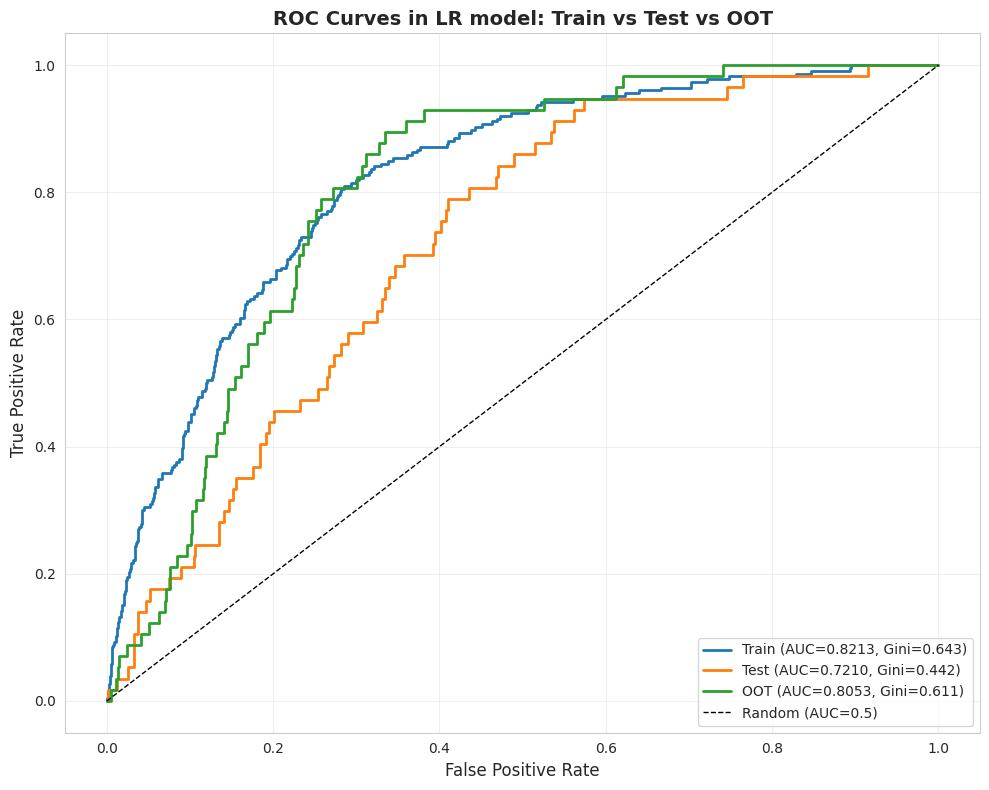

In [31]:
# ============================================
# 2. ROC CURVES (Train/Test/OOT on same plot)
# ============================================
fig, ax = plt.subplots(figsize=(10, 8))

# Train ROC
y_train_pred_proba = best_model.predict_proba(X_train_processed)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
ax.plot(fpr_train, tpr_train, label=f'Train (AUC={train_auc:.4f}, Gini={train_gini:.3f})', linewidth=2)

# Test ROC
y_test_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
ax.plot(fpr_test, tpr_test, label=f'Test (AUC={test_auc:.4f}, Gini={test_gini:.3f})', linewidth=2)

# OOT ROC
y_oot_pred_proba = best_model.predict_proba(X_oot_processed)[:, 1]
fpr_oot, tpr_oot, _ = roc_curve(y_oot, y_oot_pred_proba)
ax.plot(fpr_oot, tpr_oot, label=f'OOT (AUC={oot_auc:.4f}, Gini={oot_gini:.3f})', linewidth=2)

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves in LR model: Train vs Test vs OOT', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_LR.png', dpi=300, bbox_inches='tight')
plt.show()

## AUC COMPARISON BAR CHART

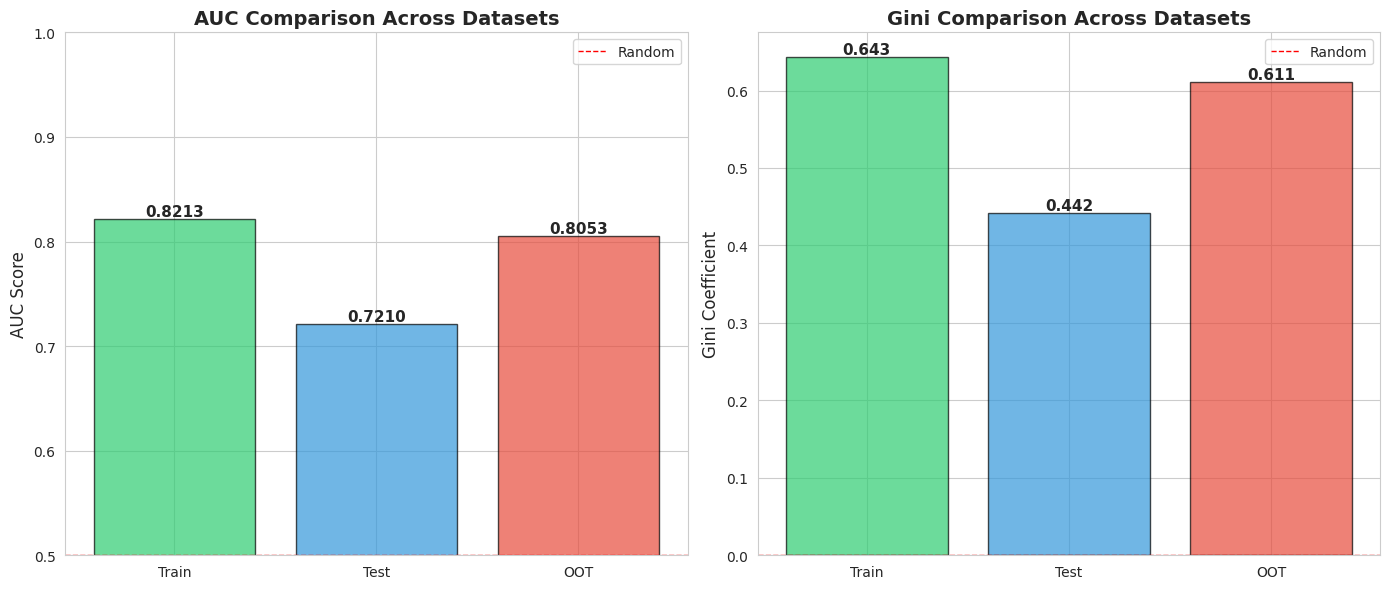

In [18]:
# ============================================
# 3. AUC COMPARISON BAR CHART
# ============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

datasets = ['Train', 'Test', 'OOT']
aucs = [train_auc, test_auc, oot_auc]
ginis = [train_gini, test_gini, oot_gini]

# AUC bars
bars1 = ax1.bar(datasets, aucs, color=['#2ecc71', '#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='Random')
ax1.set_ylabel('AUC Score', fontsize=12)
ax1.set_title('AUC Comparison Across Datasets', fontsize=14, fontweight='bold')
ax1.set_ylim([0.5, 1.0])
ax1.legend()

# Add value labels on bars
for bar, auc_val in zip(bars1, aucs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{auc_val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Gini bars
bars2 = ax2.bar(datasets, ginis, color=['#2ecc71', '#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Random')
ax2.set_ylabel('Gini Coefficient', fontsize=12)
ax2.set_title('Gini Comparison Across Datasets', fontsize=14, fontweight='bold')
ax2.legend()

# Add value labels on bars
for bar, gini_val in zip(bars2, ginis):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{gini_val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('auc_gini_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## AUC OVER TIME (by snapshot_date)

In [20]:
# ============================================
# 4. AUC OVER TIME (by snapshot_date)
# ============================================
# Prepare predictions for temporal analysis
data_pdf['predicted_proba'] = np.nan
data_pdf.loc[train_test_pdf.index, 'predicted_proba'] = best_model.predict_proba(
    pd.concat([X_train_processed, X_test_processed], axis=0).reshape(-1, len(feature_cols))
)[:, 1]
data_pdf.loc[oot_pdf.index, 'predicted_proba'] = y_oot_pred_proba

# Calculate AUC by snapshot_date
auc_by_date = []
for date in sorted(data_pdf['snapshot_date'].unique()):
    date_data = data_pdf[data_pdf['snapshot_date'] == date]
    if len(date_data) > 0 and date_data['label'].nunique() > 1:
        date_auc = roc_auc_score(date_data['label'], date_data['predicted_proba'])
        date_gini = round(2 * date_auc - 1, 3)
        
        # Determine dataset type
        if date >= config["oot_start_date"].date():
            dataset_type = 'OOT'
        else:
            dataset_type = 'Train/Test'
        
        auc_by_date.append({
            'snapshot_date': date,
            'auc': date_auc,
            'gini': date_gini,
            'dataset': dataset_type,
            'sample_size': len(date_data)
        })

auc_time_df = pd.DataFrame(auc_by_date)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# AUC over time
colors_map = {'Train/Test': '#3498db', 'OOT': '#e74c3c'}
for dataset in auc_time_df['dataset'].unique():
    subset = auc_time_df[auc_time_df['dataset'] == dataset]
    ax1.plot(subset['snapshot_date'], subset['auc'], marker='o', 
             label=dataset, linewidth=2, markersize=6, color=colors_map[dataset])

ax1.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Random')
ax1.axvline(x=config["oot_start_date"].date(), color='green', linestyle='--', 
            linewidth=2, alpha=0.7, label='OOT Period Start')
ax1.set_xlabel('Snapshot Date', fontsize=12)
ax1.set_ylabel('AUC', fontsize=12)
ax1.set_title('AUC Temporal Stability', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Sample size over time
for dataset in auc_time_df['dataset'].unique():
    subset = auc_time_df[auc_time_df['dataset'] == dataset]
    ax2.bar(subset['snapshot_date'], subset['sample_size'], 
            label=dataset, alpha=0.7, edgecolor='black')

ax2.axvline(x=config["oot_start_date"].date(), color='green', linestyle='--', 
            linewidth=2, alpha=0.7, label='OOT Period Start')
ax2.set_xlabel('Snapshot Date', fontsize=12)
ax2.set_ylabel('Sample Size', fontsize=12)
ax2.set_title('Sample Size by Snapshot Date', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('auc_temporal_stability.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAUC by Snapshot Date:")
print(auc_time_df)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

## PRECISION-RECALL CURVES

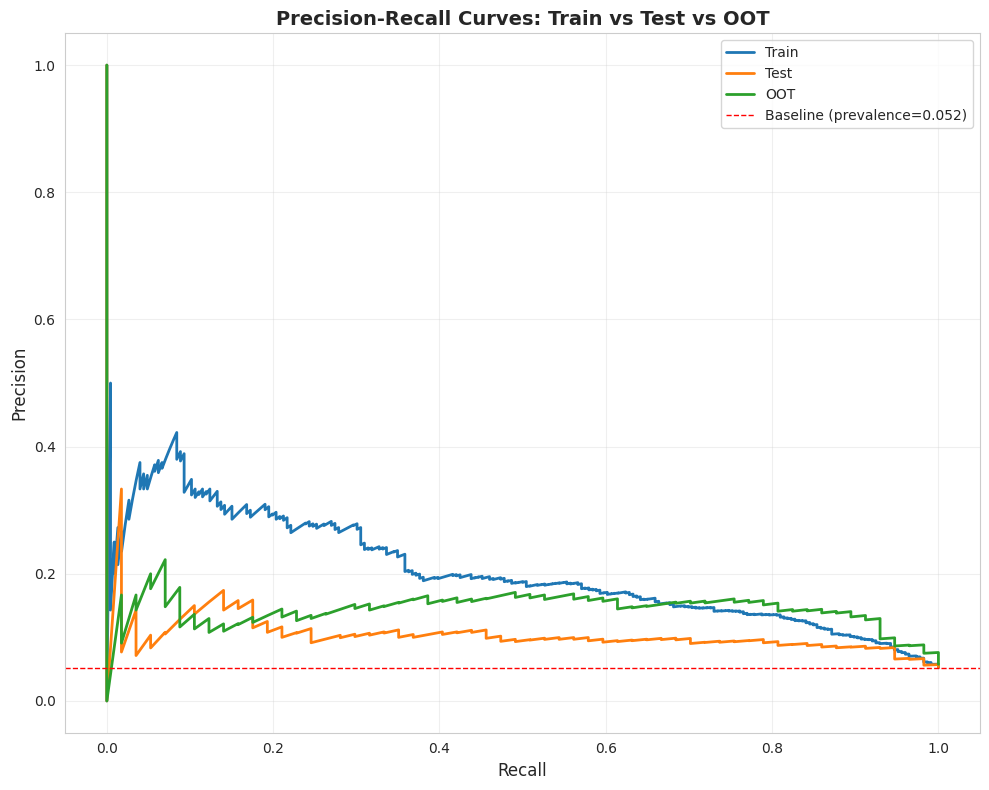

In [21]:
# ============================================
# 5. PRECISION-RECALL CURVES
# ============================================
fig, ax = plt.subplots(figsize=(10, 8))

# Train PR
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred_proba)
ax.plot(recall_train, precision_train, label=f'Train', linewidth=2)

# Test PR
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)
ax.plot(recall_test, precision_test, label=f'Test', linewidth=2)

# OOT PR
precision_oot, recall_oot, _ = precision_recall_curve(y_oot, y_oot_pred_proba)
ax.plot(recall_oot, precision_oot, label=f'OOT', linewidth=2)

# Baseline
baseline = y_train.mean()
ax.axhline(y=baseline, color='red', linestyle='--', 
           label=f'Baseline (prevalence={baseline:.3f})', linewidth=1)

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves: Train vs Test vs OOT', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## CALIBRATION PLOTS

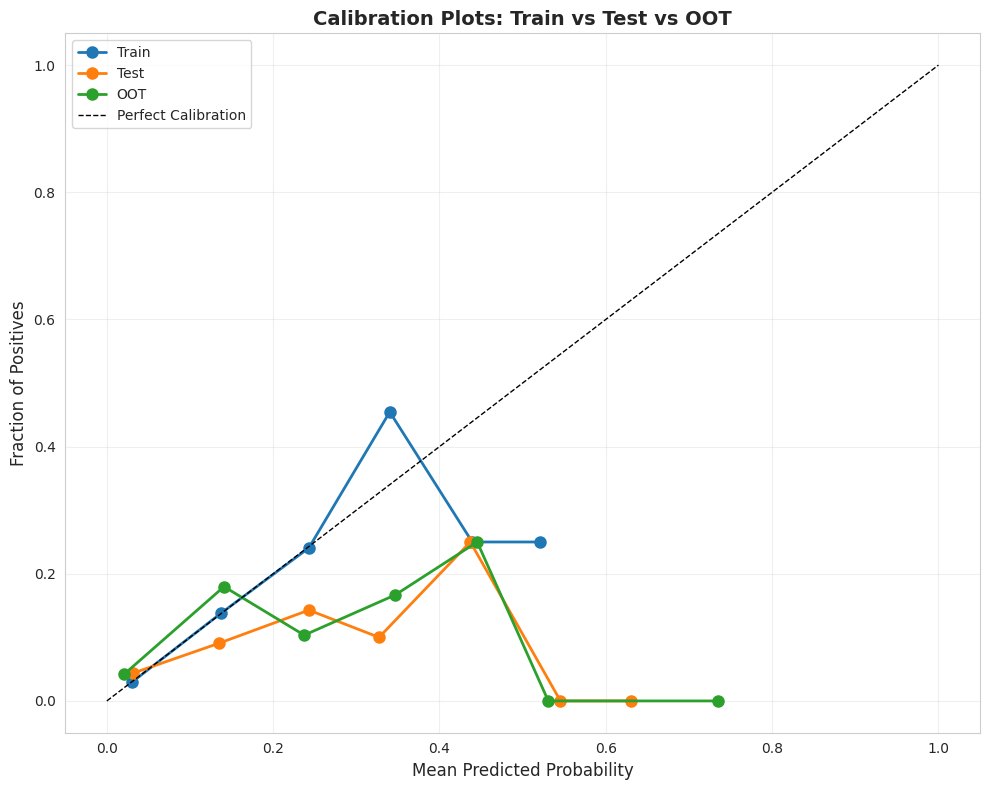

In [24]:
# ============================================
# 7. CALIBRATION PLOTS
# ============================================
fig, ax = plt.subplots(figsize=(10, 8))

for name, y_true, y_pred_proba in datasets_cm:
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=10, strategy='uniform'
    )
    ax.plot(mean_predicted_value, fraction_of_positives, marker='o', 
            linewidth=2, label=name, markersize=8)

ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=1)
ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration Plots: Train vs Test vs OOT', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('calibration_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## DISTRIBUTION OF PREDICTED PROBABILITIES

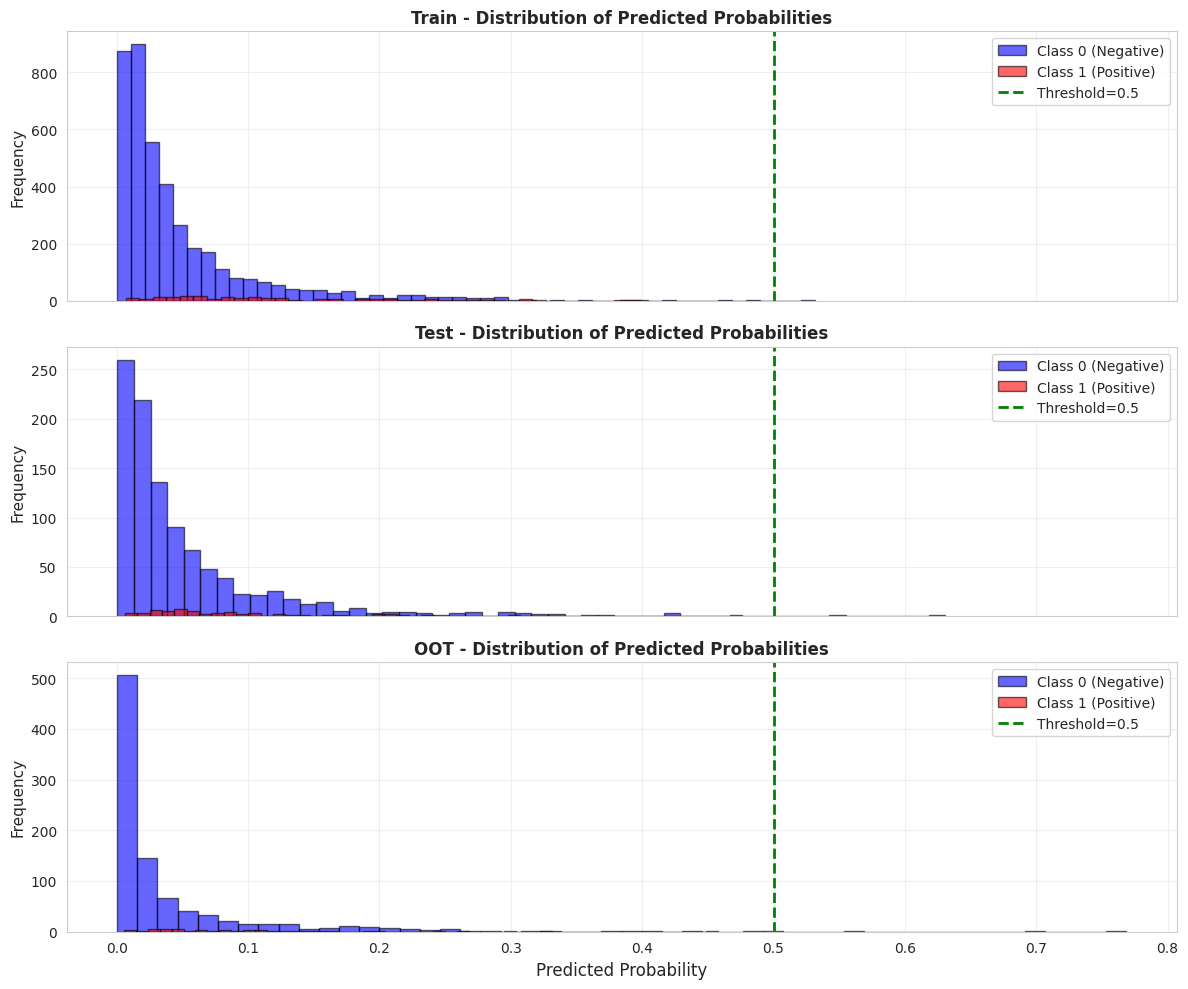

In [25]:
# ============================================
# 8. DISTRIBUTION OF PREDICTED PROBABILITIES
# ============================================
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for idx, (name, y_true, y_pred_proba) in enumerate(datasets_cm):
    # Separate by class
    proba_class_0 = y_pred_proba[y_true == 0]
    proba_class_1 = y_pred_proba[y_true == 1]
    
    axes[idx].hist(proba_class_0, bins=50, alpha=0.6, label='Class 0 (Negative)', 
                   color='blue', edgecolor='black')
    axes[idx].hist(proba_class_1, bins=50, alpha=0.6, label='Class 1 (Positive)', 
                   color='red', edgecolor='black')
    axes[idx].axvline(x=0.5, color='green', linestyle='--', linewidth=2, 
                      label='Threshold=0.5')
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{name} - Distribution of Predicted Probabilities', 
                        fontsize=12, fontweight='bold')
    axes[idx].legend(loc='best')
    axes[idx].grid(alpha=0.3)

axes[2].set_xlabel('Predicted Probability', fontsize=12)
plt.tight_layout()
plt.savefig('probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## SUMMARY STATISTICS

In [26]:
# ============================================
# SUMMARY STATISTICS
# ============================================
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"\nTrain Set:")
print(f"  AUC: {train_auc:.4f} | Gini: {train_gini:.3f} | Size: {len(y_train):,}")
print(f"\nTest Set:")
print(f"  AUC: {test_auc:.4f} | Gini: {test_gini:.3f} | Size: {len(y_test):,}")
print(f"\nOOT Set:")
print(f"  AUC: {oot_auc:.4f} | Gini: {oot_gini:.3f} | Size: {len(y_oot):,}")

print(f"\n{'='*60}")
print("All visualizations saved!")
print("="*60)


MODEL PERFORMANCE SUMMARY

Train Set:
  AUC: 0.8213 | Gini: 0.643 | Size: 4,333

Test Set:
  AUC: 0.7210 | Gini: 0.442 | Size: 1,084

OOT Set:
  AUC: 0.8053 | Gini: 0.611 | Size: 989

All visualizations saved!


In [27]:
spark.stop()

## THRESHOLD ANALYSIS FOR LOAN DEFAULT


THRESHOLD ANALYSIS

OOT Threshold Analysis:
 threshold  approval_rate  default_rate_in_approved  sensitivity  specificity  precision
      0.05       0.757331                  0.029372     0.614035     0.780043   0.145833
      0.10       0.866532                  0.042007     0.368421     0.880901   0.159091
      0.15       0.925177                  0.052459     0.157895     0.930258   0.121622
      0.20       0.956522                  0.054968     0.087719     0.959227   0.116279
      0.25       0.975733                  0.054922     0.070175     0.978541   0.166667
      0.30       0.985844                  0.056410     0.035088     0.987124   0.142857
      0.50       0.995956                  0.057868     0.000000     0.995708   0.000000


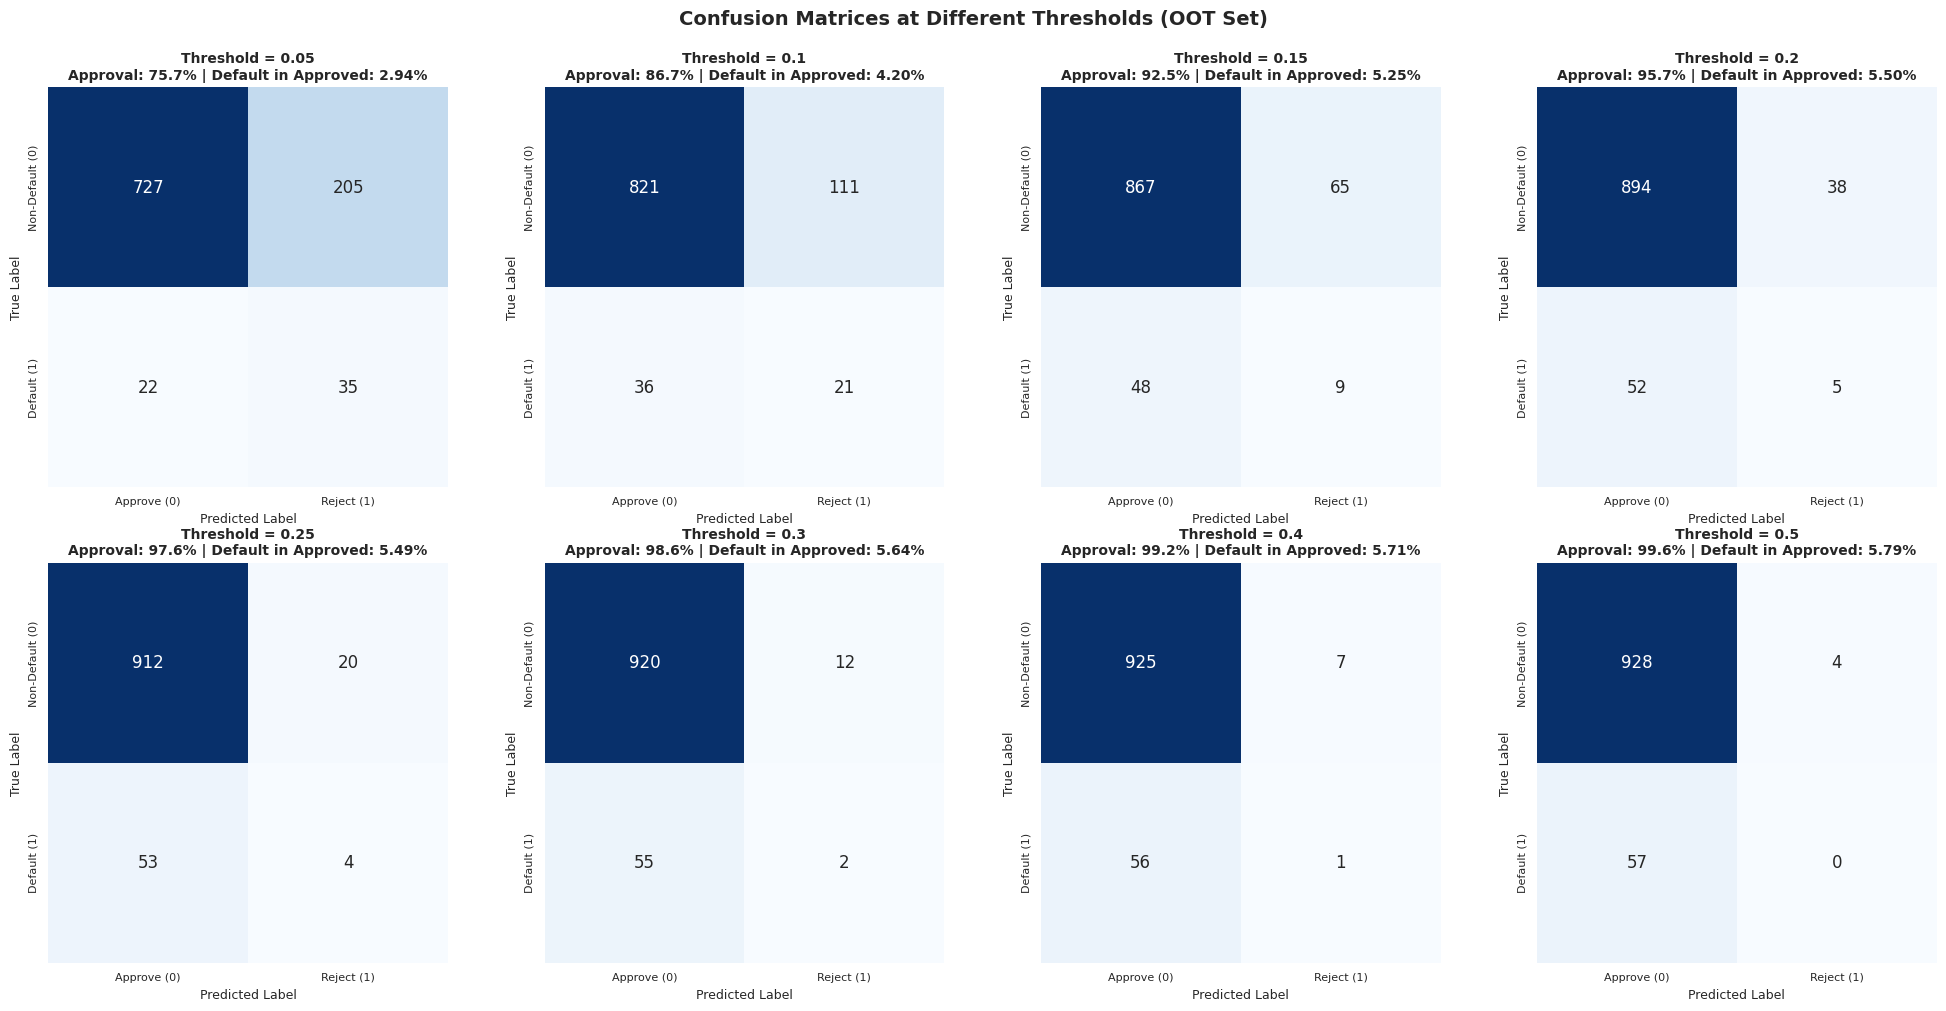

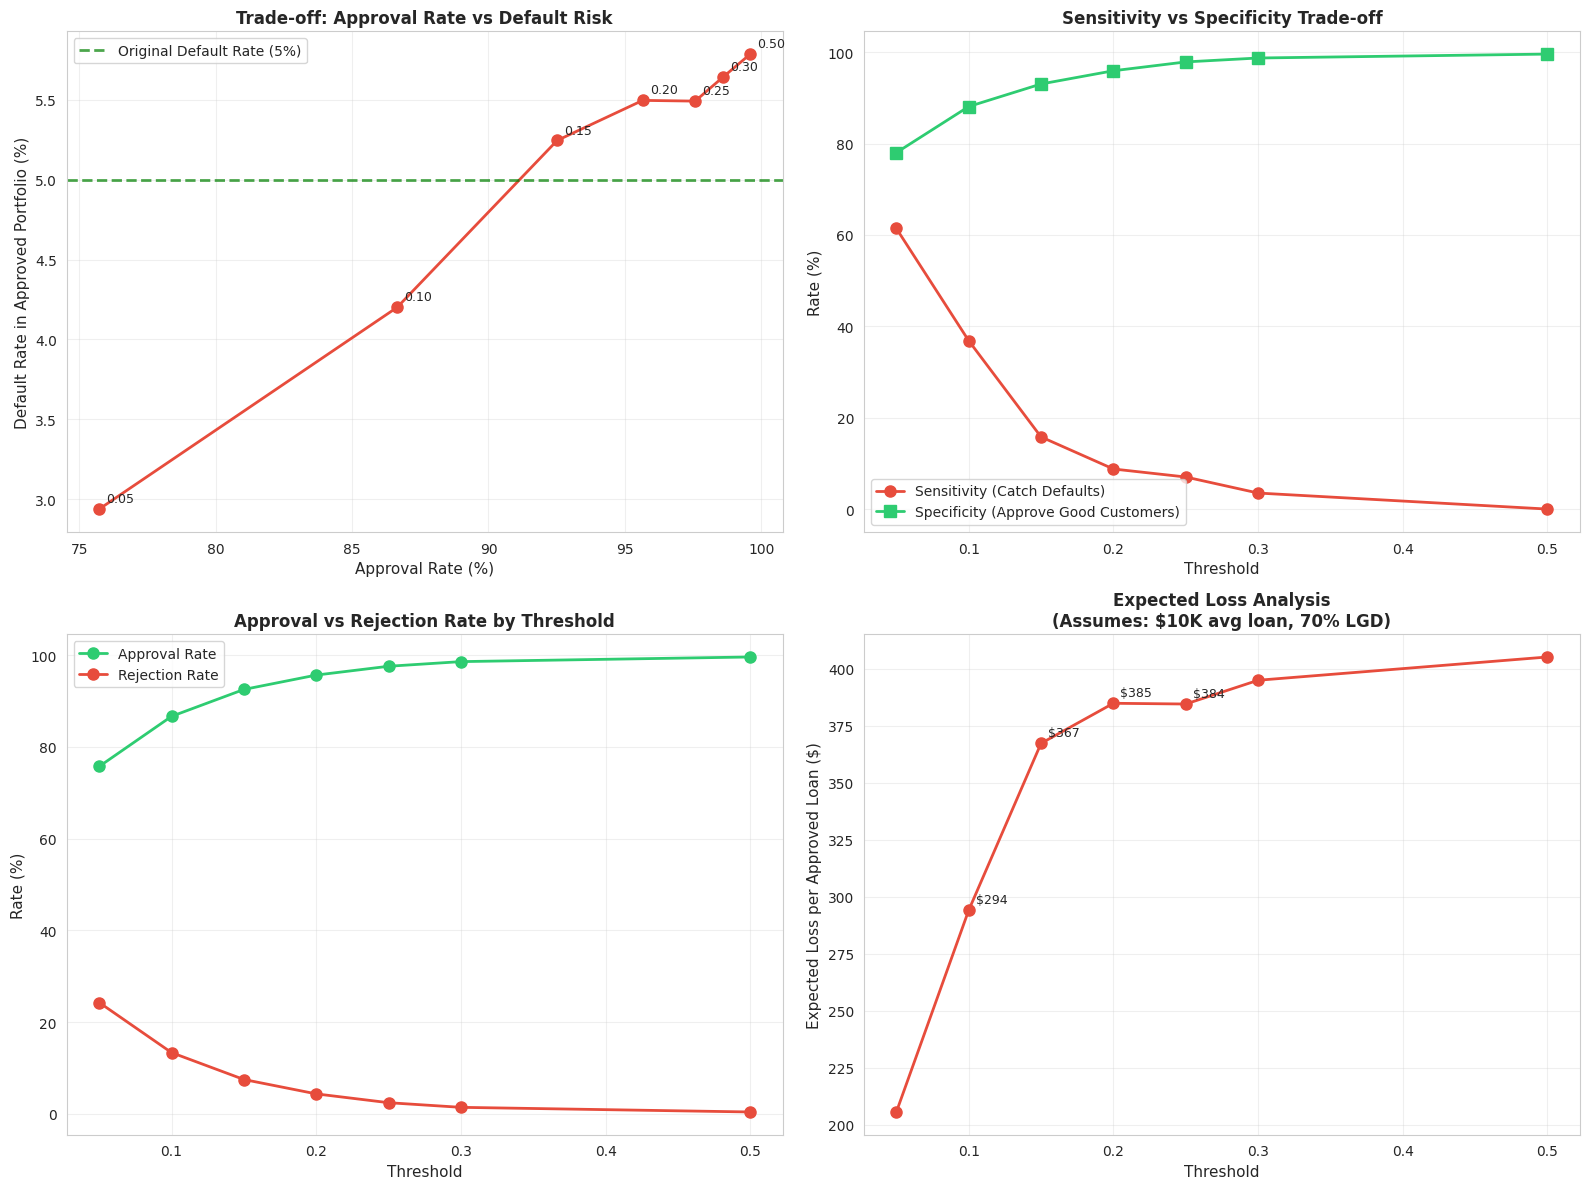


COST-BASED THRESHOLD RECOMMENDATION

📊 SCENARIO 1: Conservative Risk Strategy
------------------------------------------------------------
Target: Keep default rate in approved portfolio ≤ 3%
Recommended Threshold: 0.05
  - Approval Rate: 75.7%
  - Default Rate in Approved: 2.94%
  - Sensitivity (Defaults Caught): 61.4%
Justification: Prioritizes capital preservation and regulatory compliance.
Suitable for: Traditional banks, risk-averse lenders

📊 SCENARIO 2: Balanced Strategy
------------------------------------------------------------
Target: Balance approval rate (~70-80%) with manageable default risk (~4%)
Recommended Threshold: 0.15
  - Approval Rate: 92.5%
  - Default Rate in Approved: 5.25%
  - Sensitivity (Defaults Caught): 15.8%
Justification: Maintains competitive approval rates while keeping defaults manageable.
Suitable for: Mainstream retail banks, established lenders

📊 SCENARIO 3: Growth-Oriented Strategy
------------------------------------------------------------
Tar

In [29]:
# ============================================
# THRESHOLD ANALYSIS FOR LOAN DEFAULT
# ============================================

print("\n" + "="*60)
print("THRESHOLD ANALYSIS")
print("="*60)

# Calculate metrics at different thresholds
thresholds_to_test = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50]

def calculate_metrics_at_threshold(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total = len(y_true)
    approval_rate = (tn + fn) / total  # Predicted as 0 (approved)
    rejection_rate = (tp + fp) / total  # Predicted as 1 (rejected)
    
    # Among approved loans
    approved_count = tn + fn
    defaults_in_approved = fn
    default_rate_in_approved = fn / approved_count if approved_count > 0 else 0
    
    # Among rejected loans
    rejected_count = tp + fp
    defaults_in_rejected = tp
    
    # Sensitivity (Recall) - % of actual defaults we catch
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Specificity - % of actual non-defaults we correctly approve
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Precision - % of our rejections that are actual defaults
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {
        'threshold': threshold,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'approval_rate': approval_rate,
        'rejection_rate': rejection_rate,
        'default_rate_in_approved': default_rate_in_approved,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision
    }

# Calculate for OOT (most important for business decision)
oot_threshold_metrics = []
for thresh in thresholds_to_test:
    metrics = calculate_metrics_at_threshold(y_oot, y_oot_pred_proba, thresh)
    oot_threshold_metrics.append(metrics)

threshold_df = pd.DataFrame(oot_threshold_metrics)

print("\nOOT Threshold Analysis:")
print(threshold_df[['threshold', 'approval_rate', 'default_rate_in_approved', 
                     'sensitivity', 'specificity', 'precision']].to_string(index=False))

# ============================================
# VISUALIZATION: Multiple Confusion Matrices
# ============================================
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

selected_thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]

for idx, threshold in enumerate(selected_thresholds):
    y_pred = (y_oot_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_oot, y_pred)
    
    metrics = calculate_metrics_at_threshold(y_oot, y_oot_pred_proba, threshold)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar=False, square=True, annot_kws={"size": 12})
    
    title = f'Threshold = {threshold}\n'
    title += f'Approval: {metrics["approval_rate"]:.1%} | '
    title += f'Default in Approved: {metrics["default_rate_in_approved"]:.2%}'
    
    axes[idx].set_title(title, fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=9)
    axes[idx].set_xlabel('Predicted Label', fontsize=9)
    axes[idx].set_xticklabels(['Approve (0)', 'Reject (1)'], fontsize=8)
    axes[idx].set_yticklabels(['Non-Default (0)', 'Default (1)'], fontsize=8)

plt.suptitle('Confusion Matrices at Different Thresholds (OOT Set)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('confusion_matrices_multiple_thresholds.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# VISUALIZATION: Threshold Trade-off Curves
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Approval Rate vs Default Rate in Approved
ax1 = axes[0, 0]
ax1.plot(threshold_df['approval_rate']*100, threshold_df['default_rate_in_approved']*100, 
         marker='o', linewidth=2, markersize=8, color='#e74c3c')
for i, row in threshold_df.iterrows():
    ax1.annotate(f"{row['threshold']:.2f}", 
                xy=(row['approval_rate']*100, row['default_rate_in_approved']*100),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax1.axhline(y=5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Original Default Rate (5%)')
ax1.set_xlabel('Approval Rate (%)', fontsize=11)
ax1.set_ylabel('Default Rate in Approved Portfolio (%)', fontsize=11)
ax1.set_title('Trade-off: Approval Rate vs Default Risk', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Plot 2: Sensitivity vs Specificity
ax2 = axes[0, 1]
ax2.plot(threshold_df['threshold'], threshold_df['sensitivity']*100, 
         marker='o', linewidth=2, markersize=8, label='Sensitivity (Catch Defaults)', color='#e74c3c')
ax2.plot(threshold_df['threshold'], threshold_df['specificity']*100, 
         marker='s', linewidth=2, markersize=8, label='Specificity (Approve Good Customers)', color='#2ecc71')
ax2.set_xlabel('Threshold', fontsize=11)
ax2.set_ylabel('Rate (%)', fontsize=11)
ax2.set_title('Sensitivity vs Specificity Trade-off', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Approval Rate and Rejection Rate
ax3 = axes[1, 0]
ax3.plot(threshold_df['threshold'], threshold_df['approval_rate']*100, 
         marker='o', linewidth=2, markersize=8, label='Approval Rate', color='#2ecc71')
ax3.plot(threshold_df['threshold'], threshold_df['rejection_rate']*100, 
         marker='o', linewidth=2, markersize=8, label='Rejection Rate', color='#e74c3c')
ax3.set_xlabel('Threshold', fontsize=11)
ax3.set_ylabel('Rate (%)', fontsize=11)
ax3.set_title('Approval vs Rejection Rate by Threshold', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Expected Loss Analysis (if we assume cost structure)
ax4 = axes[1, 1]
# Assume: Average loan = $10,000, Loss given default = 70%, Profit margin = 5%
avg_loan = 10000
lgd = 0.70  # Loss Given Default
profit_margin = 0.05

expected_loss_per_approved = []
for _, row in threshold_df.iterrows():
    # Expected loss = Default rate in approved * Average loan * LGD
    exp_loss = row['default_rate_in_approved'] * avg_loan * lgd
    expected_loss_per_approved.append(exp_loss)

threshold_df['expected_loss_per_approved'] = expected_loss_per_approved

ax4.plot(threshold_df['threshold'], threshold_df['expected_loss_per_approved'], 
         marker='o', linewidth=2, markersize=8, color='#e74c3c')
for i, row in threshold_df.iterrows():
    if row['threshold'] in [0.10, 0.15, 0.20, 0.25]:
        ax4.annotate(f"${row['expected_loss_per_approved']:.0f}", 
                    xy=(row['threshold'], row['expected_loss_per_approved']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
ax4.set_xlabel('Threshold', fontsize=11)
ax4.set_ylabel('Expected Loss per Approved Loan ($)', fontsize=11)
ax4.set_title('Expected Loss Analysis\n(Assumes: $10K avg loan, 70% LGD)', 
              fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_tradeoff_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# COST-BASED OPTIMAL THRESHOLD
# ============================================
print("\n" + "="*60)
print("COST-BASED THRESHOLD RECOMMENDATION")
print("="*60)

# Scenario 1: Conservative Bank
print("\n📊 SCENARIO 1: Conservative Risk Strategy")
print("-" * 60)
print("Target: Keep default rate in approved portfolio ≤ 3%")
conservative_threshold = threshold_df[threshold_df['default_rate_in_approved'] <= 0.03]['threshold'].max()
conservative_metrics = threshold_df[threshold_df['threshold'] == conservative_threshold].iloc[0]
print(f"Recommended Threshold: {conservative_threshold:.2f}")
print(f"  - Approval Rate: {conservative_metrics['approval_rate']:.1%}")
print(f"  - Default Rate in Approved: {conservative_metrics['default_rate_in_approved']:.2%}")
print(f"  - Sensitivity (Defaults Caught): {conservative_metrics['sensitivity']:.1%}")
print(f"Justification: Prioritizes capital preservation and regulatory compliance.")
print(f"Suitable for: Traditional banks, risk-averse lenders")

# Scenario 2: Balanced Strategy  
print("\n📊 SCENARIO 2: Balanced Strategy")
print("-" * 60)
print("Target: Balance approval rate (~70-80%) with manageable default risk (~4%)")
balanced_threshold = 0.15  # Based on industry practice
balanced_metrics = threshold_df[threshold_df['threshold'] == balanced_threshold].iloc[0]
print(f"Recommended Threshold: {balanced_threshold:.2f}")
print(f"  - Approval Rate: {balanced_metrics['approval_rate']:.1%}")
print(f"  - Default Rate in Approved: {balanced_metrics['default_rate_in_approved']:.2%}")
print(f"  - Sensitivity (Defaults Caught): {balanced_metrics['sensitivity']:.1%}")
print(f"Justification: Maintains competitive approval rates while keeping defaults manageable.")
print(f"Suitable for: Mainstream retail banks, established lenders")

# Scenario 3: Growth-Oriented
print("\n📊 SCENARIO 3: Growth-Oriented Strategy")
print("-" * 60)
print("Target: Maximize approval rate while keeping defaults below 5%")
growth_threshold = threshold_df[threshold_df['default_rate_in_approved'] <= 0.05]['threshold'].min()
growth_metrics = threshold_df[threshold_df['threshold'] == growth_threshold].iloc[0]
print(f"Recommended Threshold: {growth_threshold:.2f}")
print(f"  - Approval Rate: {growth_metrics['approval_rate']:.1%}")
print(f"  - Default Rate in Approved: {growth_metrics['default_rate_in_approved']:.2%}")
print(f"  - Sensitivity (Defaults Caught): {growth_metrics['sensitivity']:.1%}")
print(f"Justification: Prioritizes market share growth and revenue generation.")
print(f"Suitable for: Fintech lenders, growth-stage companies, competitive markets")

print("\n" + "="*60)

In [32]:
# Print actual coefficient values with feature names
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': best_model.coef_[0]
}).sort_values('coefficient', ascending=False)

print(coef_df.head(20))

                                              feature  coefficient
33                                       fe_4_sum_all     0.417085
34                                       fe_5_sum_all     0.343651
1                                    Outstanding_Debt     0.232053
41                                      fe_12_sum_all     0.222359
11  Payment_Behaviour_High_spent_Large_value_payments     0.190617
9    Payment_Behaviour_Low_spent_Small_value_payments     0.165496
7    Payment_Behaviour_Low_spent_Large_value_payments     0.163354
32                                       fe_3_sum_all     0.163051
60                                              fe_11     0.161387
55                                               fe_6     0.158993
31                                       fe_2_sum_all     0.156251
24                                   age_band_Unknown     0.154160
30                                       fe_1_sum_all     0.140472
54                                               fe_5     0.13

In [33]:
print(coef_df.tail(15))

                          feature  coefficient
43                  fe_14_sum_all    -0.061523
18  Type_of_Loan_Home_Equity_Loan    -0.068366
61                          fe_12    -0.081694
35                   fe_6_sum_all    -0.086494
0                   Annual_Income    -0.103360
49                  fe_20_sum_all    -0.113170
2              Credit_History_Age    -0.116043
64                          fe_15    -0.139103
19     Type_of_Loan_Mortgage_Loan    -0.156059
48                  fe_19_sum_all    -0.157149
4          Num_of_Delayed_Payment    -0.164832
36                   fe_7_sum_all    -0.193385
37                   fe_8_sum_all    -0.292995
38                   fe_9_sum_all    -0.496966
39                  fe_10_sum_all    -0.546702


In [35]:
# Check correlation
print(data_pdf[['Num_of_Delayed_Payment', 'label']].corr())

                        Num_of_Delayed_Payment     label
Num_of_Delayed_Payment                1.000000 -0.018674
label                                -0.018674  1.000000


In [36]:
# Check distribution
print(data_pdf.groupby('label')['Num_of_Delayed_Payment'].describe())

        count       mean         std  min   25%   50%   75%     max
label                                                              
0      6066.0  36.134685  262.486845 -3.0   8.0  13.0  18.0  4293.0
1       340.0  14.855882    7.177468  0.0  10.0  16.0  20.0    27.0
